In [1]:
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from model import Discriminator,Generator,initailize_weights
from tqdm import tqdm

In [2]:
device=torch.device('cuda' if torch.cuda.is_available else 'cpu')
lr=2e-4
batch_size=128
image_size=64
channels_img=1
z_dim=100
num_epochs=5
features_dis=64
features_gen=64
transform=transforms.Compose(
    [transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)])]

)

In [3]:
dataset=datasets.MNIST(root='dataset/',train=True,transform=transform,download=True)

In [4]:
loader=DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [5]:
gen=Generator(z_dim,channels_img,features_gen).to(device)
disc=Discriminator(channels_img,features_dis).to(device)
initailize_weights(gen)
initailize_weights(disc)
opt_gen=optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.999))
opt_disc=optim.Adam(disc.parameters(),lr=lr,betas=(0.5,0.999))
criterion=nn.BCELoss()
fixed_noise=torch.randn(32,z_dim,1,1).to(device)
writer_real=SummaryWriter(f"logs/real")
writer_fake=SummaryWriter(f"logs/fake")
step=0

In [6]:
gen.train()
disc.train()
for epoch in range(num_epochs):
    for batch_idx,(real,_) in enumerate(tqdm(loader)):
        real=real.to(device)
        noise=torch.randn((batch_size,z_dim,1,1)).to(device)
        fake=gen(noise)
        ##train Discrimnator maxmize log(D(x))+log(1-D(G(Z)))
        disc_real=disc(real).reshape(-1)
        loss_disc_real=criterion(disc_real,torch.ones_like(disc_real))
        disc_fake=disc(fake).reshape(-1)
        loss_disc_fake=criterion(disc_fake,torch.zeros_like(disc_fake))
        loss_disc=(loss_disc_real+loss_disc_fake)/2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()
        ##train generator min log(1-D(G(z))) -->the same --> max log(D(G(Z)))
        output=disc(fake).reshape(-1)
        loss_gen=criterion(output,torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        if batch_idx==0:
            with torch.no_grad():
                fake=gen(fixed_noise)
                
                img_grid_fake=torchvision.utils.make_grid(fake[:32],normalize=True)
                img_grid_real=torchvision.utils.make_grid(real[:32],normalize=True)

                writer_fake.add_image(
                    "Fake Image each batch",img_grid_fake,global_step=step
                )
                writer_real.add_image(
                    "real Image each batch",img_grid_real,global_step=step
                )
                
                step+=1

100%|██████████| 469/469 [24:29<00:00,  3.13s/it]


In [34]:
#save gen
torch.save(gen.state_dict(),'pre_trained_DCGAN_gen_2022-04-19.gz')

In [35]:
#save disc
torch.save(disc.state_dict(),'pre_trained_DCGAN_disc_2022-04-19.gz')

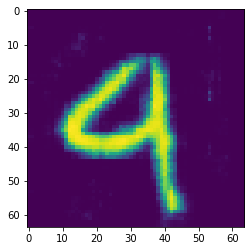

In [32]:
import matplotlib.pyplot as plt
n=torch.randn((1,z_dim,1,1))
o=gen(n.to(device))
plt.imshow(o.squeeze().detach().cpu())